In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-signal/model.pt
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A01T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A04E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A08T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A03E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A09E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A06E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A06T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A02T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A05E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A03T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A07E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A09T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A08E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A07T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A05T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A02E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A01E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A04T.gdf
/kaggle/input/eeg-signal/normalized/train_data.csv
/kaggle/input/eeg-signal/normalized/test_data.csv
/

In [2]:
!pip install mne
!pip install optuna

In [3]:
import wandb
wandb.login(key='e8b5197b26c6afeb71d44e9a9f6fa9c889efb030')
import mne
import numpy as np
import torch


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
file_paths = [f"/kaggle/input/eeg-signal/BCICIV_2a_gdf/A0{i}T.gdf" for i in range(1, 10)]  

all_data = []
all_labels = []

event_ids = {
    'left_hand': 7,   
    'right_hand': 8,   
    'feet': 9,         
    'tongue': 10       
}

for file_path in file_paths:
    raw = mne.io.read_raw_gdf(file_path, preload=True)
    raw.notch_filter(freqs=50)# Notch filter
    raw.filter(8., 30., fir_design='firwin')#Band-Pass Filter to Retain Frequencies of Interest
    raw.set_eeg_reference('average')# Re-reference the EEG Signals
    
    events, event_dict = mne.events_from_annotations(raw)
    print(f"Available events in {file_path}: {event_dict}")
    
    available_event_ids = {key: event_ids[key] for key in event_ids if event_ids[key] in event_dict.values()}
    
    if not available_event_ids:
        print(f"No motor imagery tasks found in {file_path}. Skipping this file.")
        continue  
    
    epochs = mne.Epochs(raw, events, event_id=available_event_ids, tmin=0, tmax=4, baseline=None, preload=True)
    
    X = epochs.get_data() 
    X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    y = epochs.events[:, -1] - min(available_event_ids.values())  
    
    all_data.append(X_normalized)
    all_labels.append(y)

X_combined = np.concatenate(all_data, axis=0) 
y_combined = np.concatenate(all_labels, axis=0)  

X_tensor = torch.tensor(X_combined, dtype=torch.float32).unsqueeze(1) 
y_tensor = torch.tensor(y_combined, dtype=torch.long)


Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A01T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info struct

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A02T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info struct

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A03T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info struct

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A04T.gdf: {'1023': 1, '1072': 2, '32766': 3, '768': 4, '769': 5, '770': 6, '771': 7, '772': 8}
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 1001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =     

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A05T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info struct

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A06T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info struct

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A07T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info struct

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A08T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info struct

/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Available events in /kaggle/input/eeg-signal/BCICIV_2a_gdf/A09T.gdf: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, 
                 num_classes, 
                 Chans=22, 
                 Samples=501, 
                 dropoutRate=0.5, 
                 kernLength=64, 
                 F1=8, 
                 D=2, 
                 F2=16, 
                 norm_rate=0.25):
        super(EEGNet, self).__init__()

        self.firstconv = nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, kernLength), padding=(0, kernLength // 2), bias=False),
            nn.BatchNorm2d(F1)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(F1, F1 * D, kernel_size=(Chans, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(p=dropoutRate)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(F1 * D, F1 * D, kernel_size=(1, 16), padding=(0, 16 // 2), groups=F1 * D, bias=False),
            nn.Conv2d(F1 * D, F2, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(p=dropoutRate)
        )

        self.flattened_size = self._get_flattened_size(Chans, Samples)

        self.classify = nn.Linear(self.flattened_size, num_classes)

    def _get_flattened_size(self, Chans, Samples):
        with torch.no_grad():
            x = torch.zeros(1, 1, Chans, Samples)
            x = self.firstconv(x)
            x = self.depthwiseConv(x)
            x = self.separableConv(x)
            return x.shape[1] * x.shape[2] * x.shape[3]

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x


In [6]:
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

train_dataset = EEGDataset(X_train, y_train)
test_dataset = EEGDataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(torch.unique(y_tensor))
Chans = X_tensor.shape[2]
Samples = X_tensor.shape[3]

model = EEGNet(num_classes=num_classes, Chans=Chans, Samples=Samples)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
import copy
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
num_epochs = 30
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y_batch.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    model.eval()
    val_running_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_running_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch.data)

    val_loss = val_running_loss / len(test_dataset)
    val_acc = val_correct.double() / len(test_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())



Epoch 1/30, Train Loss: 1.3984, Train Acc: 0.2554, Val Loss: 1.3687, Val Acc: 0.3388
Epoch 2/30, Train Loss: 1.3606, Train Acc: 0.3131, Val Loss: 1.3272, Val Acc: 0.3633
Epoch 3/30, Train Loss: 1.3176, Train Acc: 0.3539, Val Loss: 1.2722, Val Acc: 0.4143
Epoch 4/30, Train Loss: 1.2639, Train Acc: 0.4014, Val Loss: 1.2323, Val Acc: 0.4633
Epoch 5/30, Train Loss: 1.2380, Train Acc: 0.4213, Val Loss: 1.2024, Val Acc: 0.4653
Epoch 6/30, Train Loss: 1.2007, Train Acc: 0.4341, Val Loss: 1.1860, Val Acc: 0.4714
Epoch 7/30, Train Loss: 1.1786, Train Acc: 0.4642, Val Loss: 1.1540, Val Acc: 0.4755
Epoch 8/30, Train Loss: 1.1630, Train Acc: 0.4785, Val Loss: 1.1236, Val Acc: 0.5082
Epoch 9/30, Train Loss: 1.1321, Train Acc: 0.4877, Val Loss: 1.1053, Val Acc: 0.5000
Epoch 10/30, Train Loss: 1.1004, Train Acc: 0.5087, Val Loss: 1.0658, Val Acc: 0.5327
Epoch 11/30, Train Loss: 1.0880, Train Acc: 0.5092, Val Loss: 1.0429, Val Acc: 0.5571
Epoch 12/30, Train Loss: 1.0692, Train Acc: 0.5414, Val Loss: 1

Test Accuracy: 0.6633
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       130
           1       0.70      0.78      0.74       130
           2       0.57      0.52      0.54       115
           3       0.70      0.56      0.62       115

    accuracy                           0.66       490
   macro avg       0.66      0.66      0.65       490
weighted avg       0.66      0.66      0.66       490



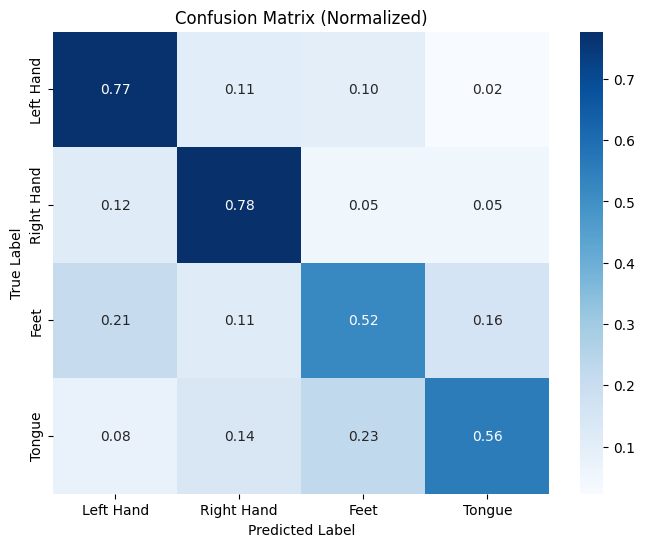

In [9]:
model.load_state_dict(best_model_wts)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']  # Thay thế bằng tên lớp của bạn

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState
from torch.utils.data import Dataset, DataLoader
import copy
import numpy as np


def objective(trial):
    dropoutRate = trial.suggest_float('dropoutRate', 0.1, 0.7, step=0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    F1 = trial.suggest_int('F1', 4, 16, step=4)
    D = trial.suggest_int('D', 1, 4)
    kernLength = trial.suggest_int('kernLength', 16, 128, step=16)
    F2 = F1 * D

    model = EEGNet(
        num_classes=num_classes,
        Chans=Chans,
        Samples=Samples,
        dropoutRate=dropoutRate,
        kernLength=kernLength,
        F1=F1,
        D=D,
        F2=F2
    )
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 50 

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_correct = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == y_batch.data)

        val_acc = val_correct.double() / len(test_dataset)

        trial.report(val_acc.item(), epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_acc.item()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value (Validation Accuracy): {:.4f}'.format(trial.value))

print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

best_params = trial.params

best_model = EEGNet(
    num_classes=num_classes,
    Chans=Chans,
    Samples=Samples,
    dropoutRate=best_params['dropoutRate'],
    kernLength=best_params['kernLength'],
    F1=best_params['F1'],
    D=best_params['D'],
    F2=best_params['F1'] * best_params['D']
)
best_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

num_epochs = 100  
best_model_wts = copy.deepcopy(best_model.state_dict())
best_val_acc = 0.0

for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y_batch.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct.double() / len(train_dataset)

    best_model.eval()
    val_running_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = best_model(X_batch)
            loss = criterion(outputs, y_batch)

            val_running_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch.data)

    val_loss = val_running_loss / len(test_dataset)
    val_acc = val_correct.double() / len(test_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(best_model.state_dict())

best_model.load_state_dict(best_model_wts)



[I 2024-12-15 03:14:07,375] A new study created in memory with name: no-name-999ea86a-921b-4cf0-8998-90e4096939ec
/tmp/ipykernel_17/443047982.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-12-15 03:33:40,699] Trial 0 finished with value: 0.4775510204081633 and parameters: {'dropoutRate': 0.2, 'learning_rate': 2.5811782009120617e-05, 'F1': 16, 'D': 3, 'kernLength': 32}. Best is trial 0 with value: 0.4775510204081633.
[I 2024-12-15 03:51:00,264] Trial 1 finished with value: 0.40816326530612246 and parameters: {'dropoutRate': 0.30000000000000004, 'learning_rate': 1.6491819653488852e-05, 'F1': 8, 'D': 4, 'kernLength': 128}. Best is trial 0 with value: 0.4775510204081633.
[I 2024-12-15 04:01:34,241] Trial 2 finished with value: 0.6061224489795919 and

Number of finished trials: 50
Best trial:
  Value (Validation Accuracy): 0.7429
  Params:
    dropoutRate: 0.4
    learning_rate: 0.0021039858267616505
    F1: 12
    D: 4
    kernLength: 96
Epoch 1/100, Train Loss: 1.3405, Train Acc: 0.3437, Val Loss: 1.2444, Val Acc: 0.4020
Epoch 2/100, Train Loss: 1.1959, Train Acc: 0.4627, Val Loss: 1.1372, Val Acc: 0.4857
Epoch 3/100, Train Loss: 1.0898, Train Acc: 0.5204, Val Loss: 1.0887, Val Acc: 0.5041
Epoch 4/100, Train Loss: 1.0406, Train Acc: 0.5572, Val Loss: 1.0885, Val Acc: 0.4918
Epoch 5/100, Train Loss: 0.9682, Train Acc: 0.5787, Val Loss: 1.0076, Val Acc: 0.5327
Epoch 6/100, Train Loss: 0.9404, Train Acc: 0.6011, Val Loss: 0.9871, Val Acc: 0.5531
Epoch 7/100, Train Loss: 0.9015, Train Acc: 0.6216, Val Loss: 0.9504, Val Acc: 0.5673
Epoch 8/100, Train Loss: 0.8527, Train Acc: 0.6476, Val Loss: 0.9641, Val Acc: 0.5796
Epoch 9/100, Train Loss: 0.8471, Train Acc: 0.6517, Val Loss: 0.9163, Val Acc: 0.5898
Epoch 10/100, Train Loss: 0.8133, T

<All keys matched successfully>

Epoch 1/100, Train Loss: 1.3389, Train Acc: 0.3320, Val Loss: 1.2539, Val Acc: 0.4184
Epoch 2/100, Train Loss: 1.2241, Train Acc: 0.4356, Val Loss: 1.1632, Val Acc: 0.4878
Epoch 3/100, Train Loss: 1.1186, Train Acc: 0.5077, Val Loss: 1.0892, Val Acc: 0.5082
Epoch 4/100, Train Loss: 1.0459, Train Acc: 0.5485, Val Loss: 1.0815, Val Acc: 0.4959
Epoch 5/100, Train Loss: 1.0024, Train Acc: 0.5587, Val Loss: 1.0342, Val Acc: 0.5265
Epoch 6/100, Train Loss: 0.9682, Train Acc: 0.5899, Val Loss: 0.9974, Val Acc: 0.5633
Epoch 7/100, Train Loss: 0.9195, Train Acc: 0.6170, Val Loss: 0.9893, Val Acc: 0.5490
Epoch 8/100, Train Loss: 0.8791, Train Acc: 0.6313, Val Loss: 1.0247, Val Acc: 0.5204
Epoch 9/100, Train Loss: 0.8615, Train Acc: 0.6353, Val Loss: 0.9477, Val Acc: 0.5612
Epoch 10/100, Train Loss: 0.8111, Train Acc: 0.6517, Val Loss: 0.9194, Val Acc: 0.6061
Epoch 11/100, Train Loss: 0.7943, Train Acc: 0.6747, Val Loss: 0.9100, Val Acc: 0.6082
Epoch 12/100, Train Loss: 0.7467, Train Acc: 0.6987,

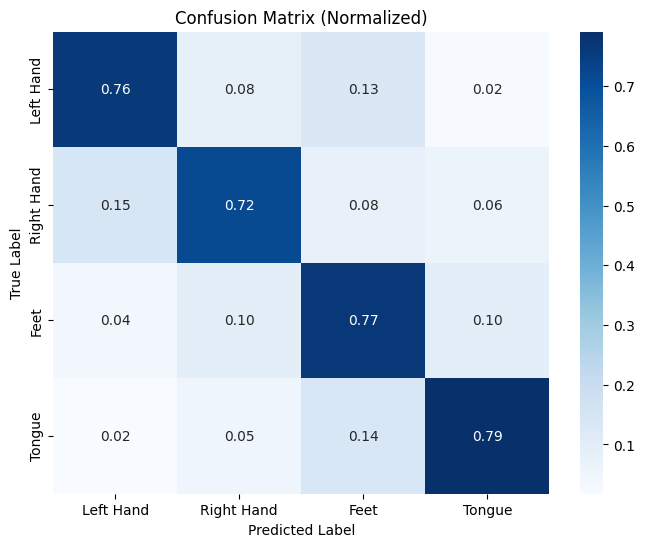

In [11]:
best_params = trial.params

best_model = EEGNet(
    num_classes=num_classes,
    Chans=Chans,
    Samples=Samples,
    dropoutRate=best_params['dropoutRate'],
    kernLength=best_params['kernLength'],
    F1=best_params['F1'],
    D=best_params['D'],
    F2=best_params['F1'] * best_params['D']
)
best_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

num_epochs = 100
best_val_acc = 0.0
best_model_wts = copy.deepcopy(best_model.state_dict())

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y_batch.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    best_model.eval()
    val_running_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = best_model(X_batch)
            loss = criterion(outputs, y_batch)

            val_running_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch.data)

    val_loss = val_running_loss / len(test_dataset)
    val_acc = val_correct.double() / len(test_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(best_model.state_dict())
        
best_model.load_state_dict(best_model_wts)

best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = best_model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']  # Thay thế bằng tên lớp của bạn

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
